# **Importing Necessary Libraries**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# **Data Loading and Preprocessing**

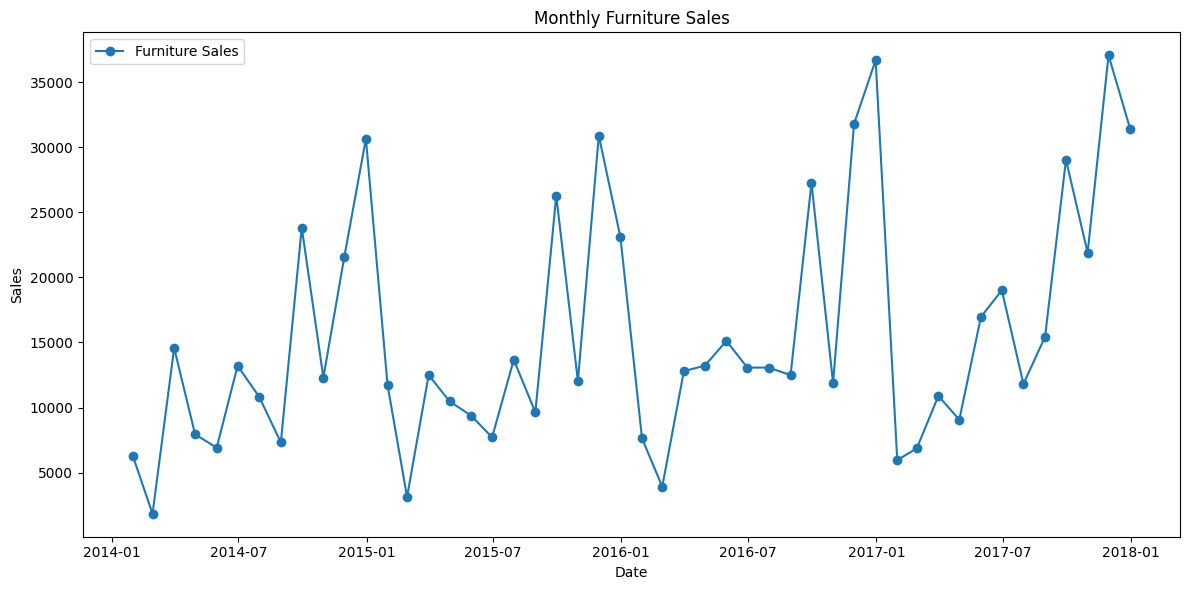

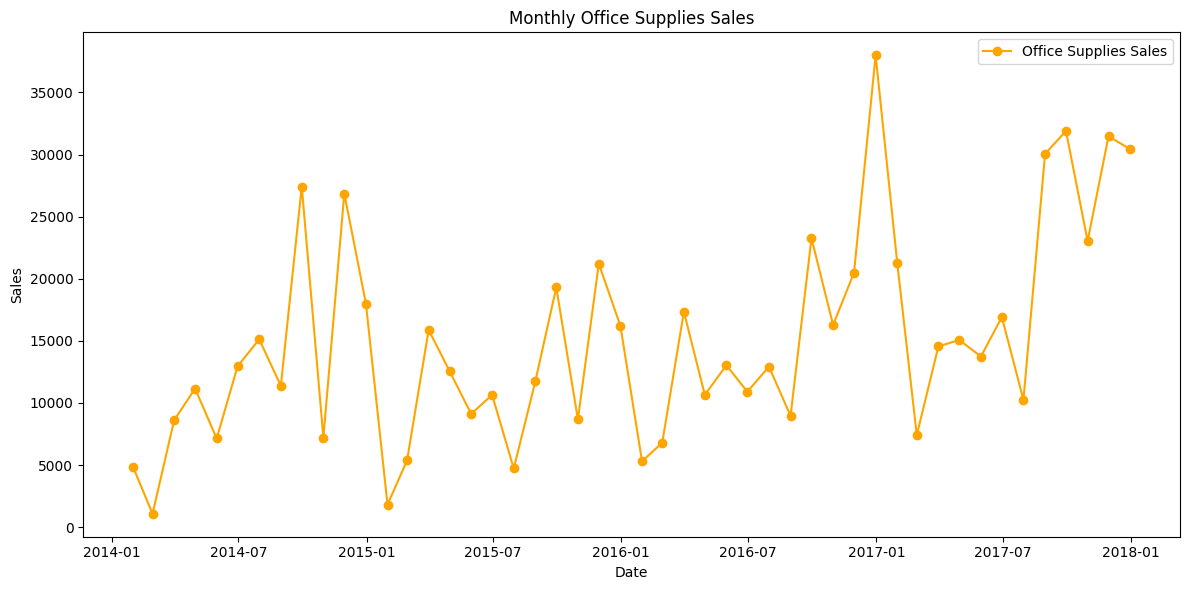

In [4]:

df = pd.read_excel('PATH TO DATASET', parse_dates=['Order Date'])

# Set the date column as the index
df.set_index('Order Date', inplace=True)

# Separate the dataset into Furniture and Office Supplies
df_furniture = df[df['Category'] == 'Furniture']
df_office = df[df['Category'] == 'Office Supplies']

# Resample to monthly sales (summing up sales)
furniture_sales = df_furniture['Sales'].resample('M').sum()
office_sales = df_office['Sales'].resample('M').sum()

# Plot original time series for each category
plt.figure(figsize=(12,6))
plt.plot(furniture_sales, marker='o', label='Furniture Sales')
plt.title('Monthly Furniture Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(office_sales, marker='o', color='orange', label='Office Supplies Sales')
plt.title('Monthly Office Supplies Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# **Time Series Decomposition and Checking for Stationarity**

If the p-value is greater than 0.05, the series may be non-stationary.
 In that case, differencing (or other transformations) might be needed.

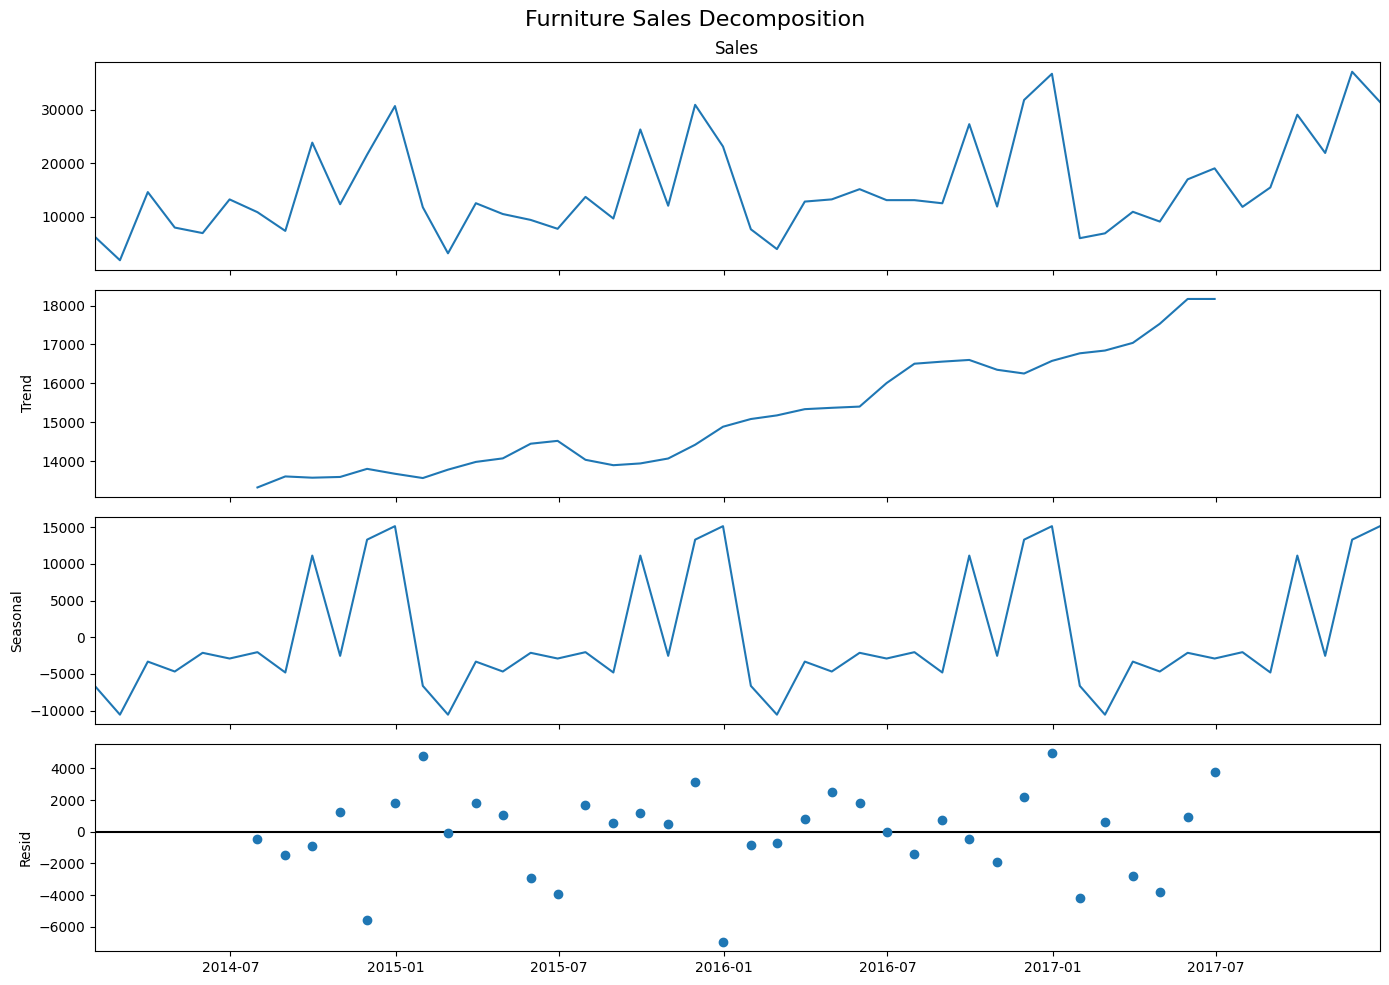

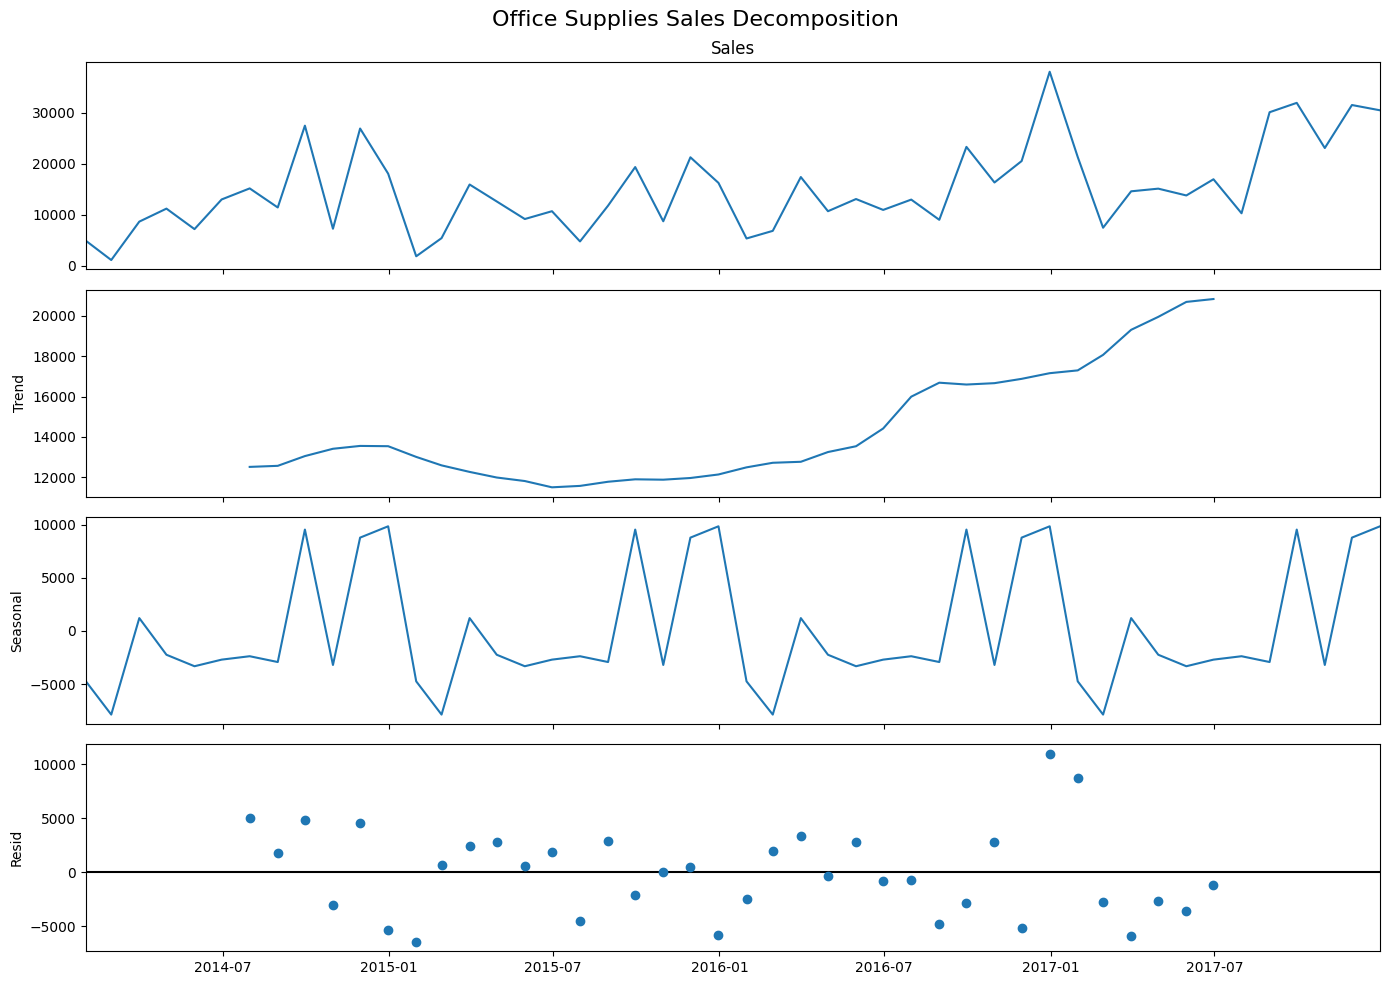


ADF Test: Furniture Sales
ADF Statistic                  -4.699026
p-value                         0.000085
# Lags Used                     0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774

ADF Test: Office Supplies Sales
ADF Statistic                  -1.905481
p-value                         0.329487
# Lags Used                     2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344


In [5]:

# Decompose the series to observe trend, seasonality, and residuals
def decompose_plot(series, title):
    decomposition = seasonal_decompose(series, model='additive')
    fig = decomposition.plot()
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()

decompose_plot(furniture_sales, 'Furniture Sales Decomposition')
decompose_plot(office_sales, 'Office Supplies Sales Decomposition')

# Check for Stationarity using Augmented Dickey-Fuller Test

def adf_test(series, title=''):
    print(f'\nADF Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())

adf_test(furniture_sales, 'Furniture Sales')
adf_test(office_sales, 'Office Supplies Sales')


# **ARIMA Model Building and Forecasting**

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -367.221
Date:                Tue, 18 Feb 2025   AIC                            740.441
Time:                        07:54:11   BIC                            745.107
Sample:                    01-31-2014   HQIC                           742.052
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0079      0.260      0.030      0.976      -0.502       0.518
ma.L1         -0.6164      0.240     -2.573      0.010      -1.086      -0.147
sigma2       8.25e+07   1.41e-10   5.85e+17      0.0

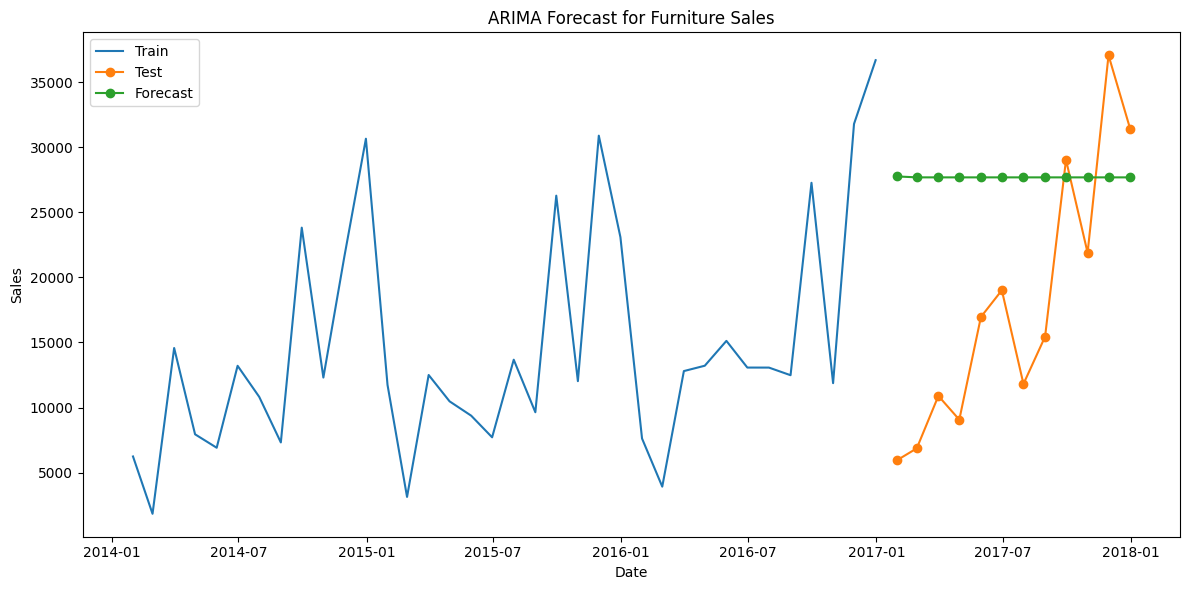

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -363.093
Date:                Tue, 18 Feb 2025   AIC                            732.186
Time:                        07:54:12   BIC                            736.852
Sample:                    01-31-2014   HQIC                           733.796
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2019      0.294     -0.687      0.492      -0.778       0.374
ma.L1         -0.5196      0.250     -2.080      0.038      -1.009      -0.030
sigma2      6.737e+07   2.62e-10   2.57e+17      0.0

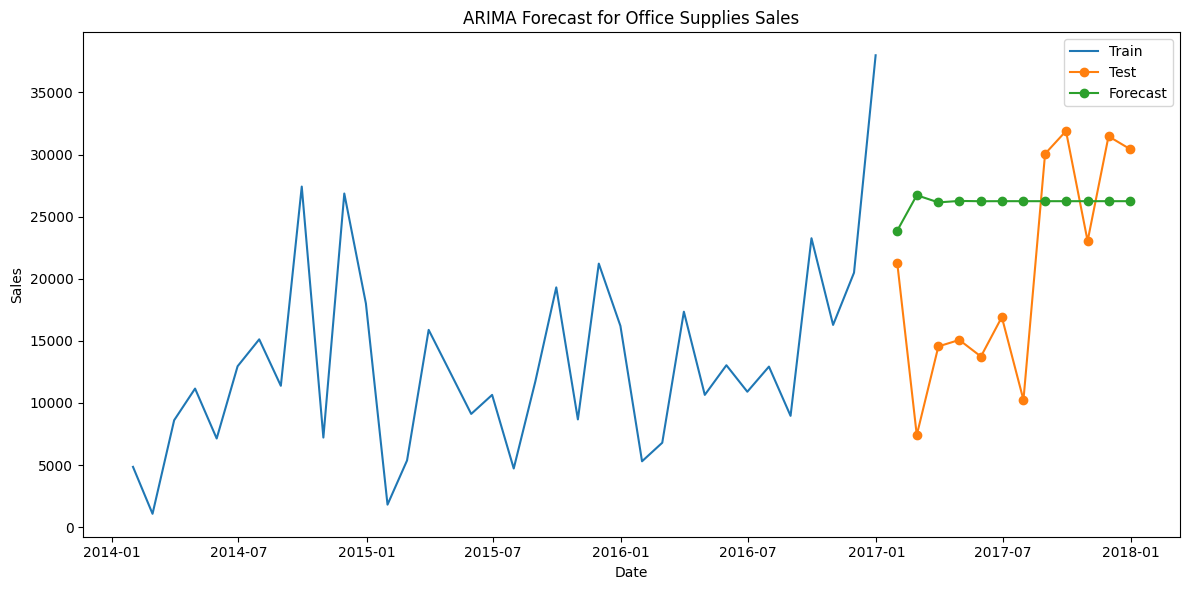

In [8]:

train_furniture = furniture_sales.iloc[:-12]
test_furniture = furniture_sales.iloc[-12:]

train_office = office_sales.iloc[:-12]
test_office = office_sales.iloc[-12:]
# Here, we use an ARIMA model with order (1, 1, 1) as a starting point.

model_furniture = ARIMA(train_furniture, order=(1,1,1))
model_fit_furniture = model_furniture.fit()
print(model_fit_furniture.summary())

forecast_furniture = model_fit_furniture.forecast(steps=12)
rmse_furniture = np.sqrt(mean_squared_error(test_furniture, forecast_furniture))
print("Furniture Sales Test RMSE: {:.2f}".format(rmse_furniture))

plt.figure(figsize=(12,6))
plt.plot(train_furniture.index, train_furniture, label='Train')
plt.plot(test_furniture.index, test_furniture, label='Test', marker='o')
plt.plot(test_furniture.index, forecast_furniture, label='Forecast', marker='o')
plt.title('ARIMA Forecast for Furniture Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Forecasting for Office Supplies Sales
model_office = ARIMA(train_office, order=(1,1,1))
model_fit_office = model_office.fit()
print(model_fit_office.summary())

forecast_office = model_fit_office.forecast(steps=12)
rmse_office = np.sqrt(mean_squared_error(test_office, forecast_office))
print("Office Supplies Sales Test RMSE: {:.2f}".format(rmse_office))

plt.figure(figsize=(12,6))
plt.plot(train_office.index, train_office, label='Train')
plt.plot(test_office.index, test_office, label='Test', marker='o')
plt.plot(test_office.index, forecast_office, label='Forecast', marker='o')
plt.title('ARIMA Forecast for Office Supplies Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


 **As Observed from the graph, the forecast curve is just a constant straight line which indicates that ARIMA model is giving poor results for sales forecast.**

 **So, we use Seasonal ARIMA model[SARIMA] as this also captures the seasonal patterns which typically esixt when working with month-wise time series dataset.**

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -229.435
Date:                            Tue, 18 Feb 2025   AIC                            468.870
Time:                                    07:55:53   BIC                            474.547
Sample:                                01-31-2014   HQIC                           470.298
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6763      0.260      2.602      0.009       0.167       1.186
ma.L1         -0.9731      0.371   

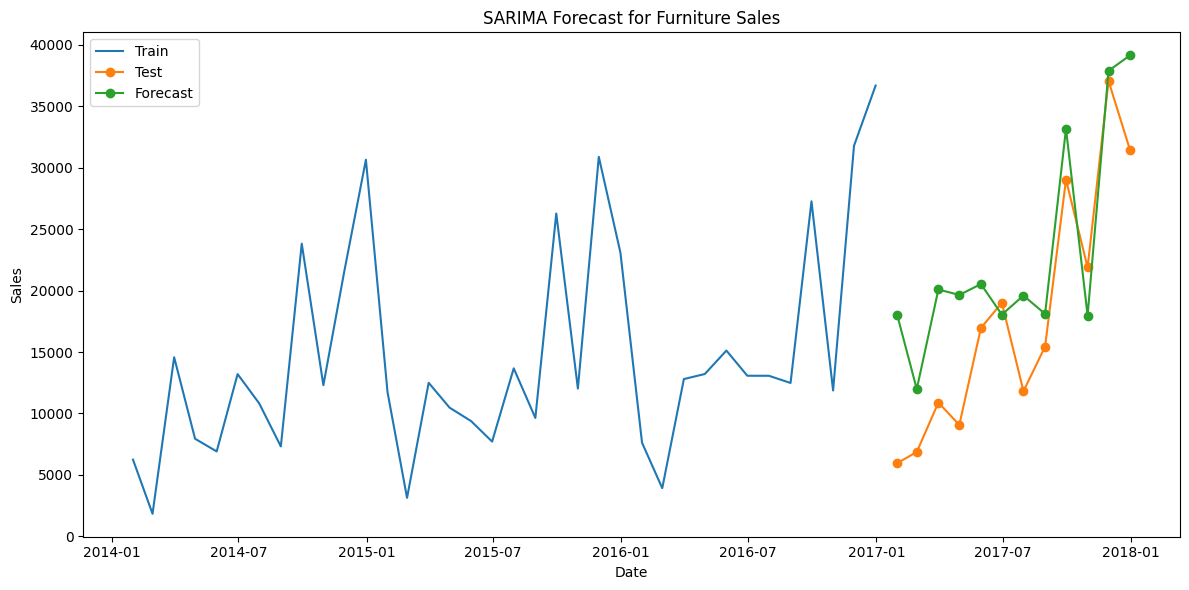

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -230.898
Date:                            Tue, 18 Feb 2025   AIC                            471.796
Time:                                    07:55:54   BIC                            477.474
Sample:                                01-31-2014   HQIC                           473.224
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4421      0.369     -1.199      0.231      -1.165       0.281
ma.L1         -0.2629      0.374   

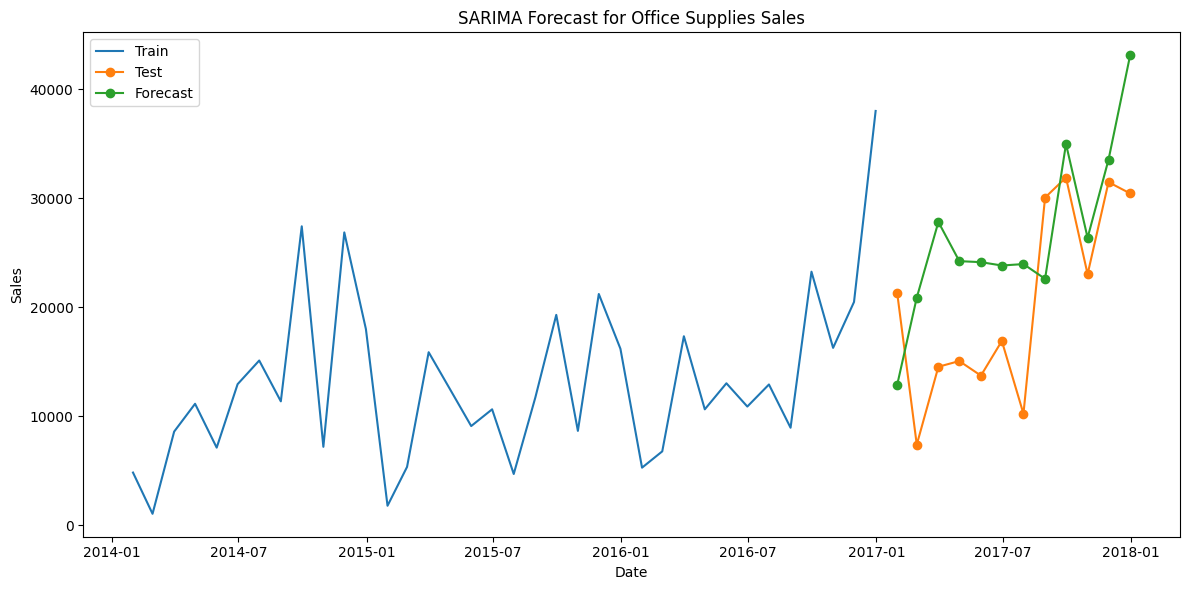

In [9]:

#SARIMA Modeling and Forecasting

# For monthly data with seasonality, we set seasonal_period=12.
# Here we use SARIMAX with order=(1,1,1) and seasonal_order=(1,1,1,12)


# Forecasting for Furniture Sales
model_furniture = SARIMAX(train_furniture, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit_furniture = model_furniture.fit(disp=False)
print(model_fit_furniture.summary())

forecast_furniture = model_fit_furniture.forecast(steps=12)
rmse_furniture = np.sqrt(mean_squared_error(test_furniture, forecast_furniture))
print("Furniture Sales Test RMSE: {:.2f}".format(rmse_furniture))

plt.figure(figsize=(12,6))
plt.plot(train_furniture.index, train_furniture, label='Train')
plt.plot(test_furniture.index, test_furniture, label='Test', marker='o')
plt.plot(test_furniture.index, forecast_furniture, label='Forecast', marker='o')
plt.title('SARIMA Forecast for Furniture Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Forecasting for Office Supplies Sales
model_office = SARIMAX(train_office, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit_office = model_office.fit(disp=False)
print(model_fit_office.summary())

forecast_office = model_fit_office.forecast(steps=12)
rmse_office = np.sqrt(mean_squared_error(test_office, forecast_office))
print("Office Supplies Sales Test RMSE: {:.2f}".format(rmse_office))

plt.figure(figsize=(12,6))
plt.plot(train_office.index, train_office, label='Train')
plt.plot(test_office.index, test_office, label='Test', marker='o')
plt.plot(test_office.index, forecast_office, label='Forecast', marker='o')
plt.title('SARIMA Forecast for Office Supplies Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


**Hence as observed, Seasonal ARIMA gives a lot better forecast results than normal ARIMA**

# **Business Insights based on my Observation**

 **Furniture Sales**

  **Stable Demand**: The ADF test (p = 0.000085) confirms that furniture sales
are stationary, meaning there’s no strong upward or downward trend.

**Short-Term Dynamics:** The SARIMAX model shows significant non-seasonal AR (0.6763, p = 0.009) and MA (-0.9731, p = 0.009) terms, indicating that recent sales values are good predictors of near-future sales.

**Seasonality:** Seasonal terms are not statistically significant, suggesting that seasonal fluctuations may be less pronounced or are effectively captured by the non-seasonal dynamics.

# **Office Supplies Sales**

**Non-Stationary Behavior:**
        The ADF test (p = 0.329487) suggests that office supplies sales are non-stationary, implying a trend or external influences are at play.

** Model Uncertainty:**

The SARIMAX model parameters for office supplies are not statistically significant (all p-values > 0.2), and the Jarque-Bera test indicates non-normal residuals. This signals that the current model is not capturing the underlying dynamics well.